# Data Augmentation

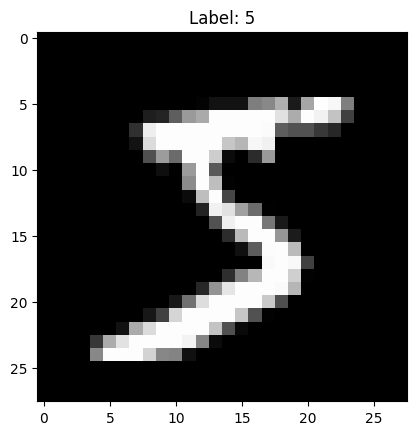

In [ ]:
import torch
import random
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
])

# Load the MNIST dataset with the transformation
dataset = datasets.MNIST('../data', train=True, download=True, transform=transform)

# Retrieve an image from the dataset
image, label = dataset[0]  # Get the first image and its label

# Convert the tensor to a numpy array and remove the batch dimension
image = image.squeeze().numpy()

# Display the image
plt.imshow(image, cmap='gray')
plt.title(f'Label: {label}')
plt.show()

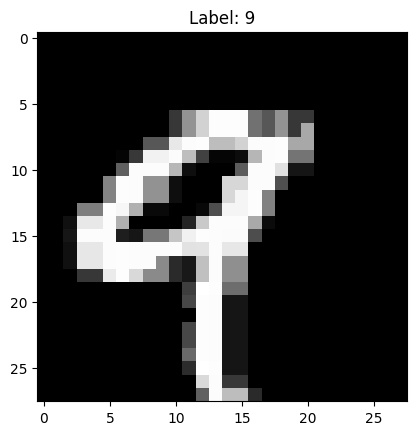

In [ ]:
import torch
import random
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image

# Custom transformation to add Gaussian noise
class AddGaussianNoise:
    def __init__(self, mean=0., std=0.1):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

# Define the augmentation pipeline with thinning and Gaussian noise
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.1307,), (0.3081,)),  # Normalize
    transforms.RandomAffine(degrees=(-5,5), translate=(0.2, 0.2), scale=(0.7, 1.3), shear=10),  # Random affine
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=1)], p=0.3),  # Gaussian blur
    transforms.RandomApply([transforms.ColorJitter(brightness=0.1, contrast=0.1)], p=0.3),
    transforms.RandomApply([AddGaussianNoise(mean=0., std=0.1)], p=0.2)  # Add Gaussian noise
])

# Load the MNIST dataset with the transformation
dataset = datasets.MNIST('../data', train=True, download=True, transform=transform)

# Retrieve an image from the dataset
image, label = dataset[4]  # Get the first image and its label

# Convert the tensor to a numpy array and remove the batch dimension
image = image * 0.3081 + 0.1307  # Reverse the normalization
image = image.squeeze().numpy()

# Display the image
plt.imshow(image, cmap='gray')
plt.title(f'Label: {label}')
plt.show()

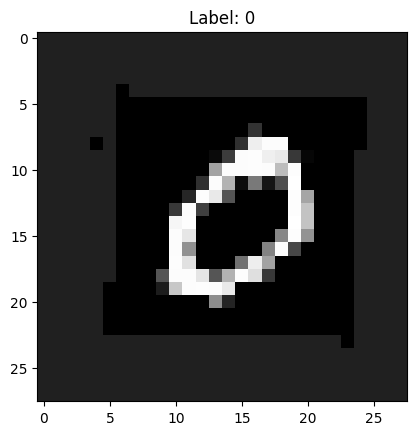

In [ ]:
import torch
import random
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image

# Custom transformation to add Gaussian noise
class AddGaussianNoise:
    def __init__(self, mean=0., std=0.1):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

# Custom transformation to drop pixel randomly
class RandomPixelDrop:
    def __init__(self, max_blobs=3, min_radius=2, max_radius=5, intensity=0.7):
        self.max_blobs = max_blobs         # Maximum number of blobs to create
        self.min_radius = min_radius       # Minimum radius of blobs
        self.max_radius = max_radius       # Maximum radius of blobs
        self.intensity = intensity         # Threshold for blob intensity
        self.background_value = (0 - 0.1307) / 0.3081  # Normalized background value

    def __call__(self, tensor):
        # Create a copy to modify
        modified = tensor.clone()

        # Generate random blobs
        for _ in range(random.randint(1, self.max_blobs)):
            # Create random position within digit bounds
            height, width = tensor.shape[1:]
            cx = random.randint(0, width-1)
            cy = random.randint(0, height-1)

            # Create grid
            x = torch.arange(width, dtype=torch.float32)
            y = torch.arange(height, dtype=torch.float32)
            grid_x, grid_y = torch.meshgrid(x, y, indexing='xy')

            # Generate random radius
            radius = random.randint(self.min_radius, self.max_radius)

            # Create circular mask
            mask = ((grid_x - cx)**2 + (grid_y - cy)**2) < radius**2
            mask = mask.float().unsqueeze(0)

            # Apply random intensity variation
            mask *= random.uniform(0.8, 1.2)

            # Threshold to create binary mask
            blob_mask = (mask > self.intensity).float()

            # Only apply to digit pixels
            digit_area = (modified > -0.5).float()  # Wider threshold for digit region
            combined_mask = (blob_mask * digit_area).bool()

            # Apply to tensor
            modified[combined_mask] = self.background_value

        return modified

    def __repr__(self):
        return (f'{self.__class__.__name__}(max_blobs={self.max_blobs}, '
                f'radius=({self.min_radius}-{self.max_radius}), '
                f'intensity={self.intensity})')

# Updated augmentation pipeline with pixel dropping
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    transforms.RandomAffine(degrees=(-5,5), translate=(0.1, 0.1), scale=(0.6, 1.3), shear=10),
    transforms.RandomApply([AddGaussianNoise(mean=0., std=0.1)], p=0.2),  # Add Gaussian noise
    transforms.RandomApply([RandomPixelDrop(
        max_blobs=2,
        min_radius=1,
        max_radius=2,
        intensity=0.6
    )], p=0.4)
])

# Load the MNIST dataset with the new transformation
dataset = datasets.MNIST('../data', train=True, download=True, transform=transform)

# Retrieve and display an image
image, label = dataset[1]

# Reverse normalization for display
image = image * 0.3081 + 0.1307  # Revert normalization
image = image.squeeze().numpy()

plt.imshow(image, cmap='gray')
plt.title(f'Label: {label}')
plt.show()

# Training Model

Using random seed: 16059
Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:01<00:00, 5.07MB/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 65.2kB/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 5.26MB/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.304725
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.272077
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.272708
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.275848
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.095652
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.904788
Train Epoch: 1 [3840/60000 (6%)]	Loss: 1.264906
Train Epoch: 1 [4480/60000 (7%)]	Loss: 1.348885
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.125845
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.594338
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.898117
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.680346
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.562153
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.607661
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.400093
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.376331
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.549874
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.331756
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.444405
Tr

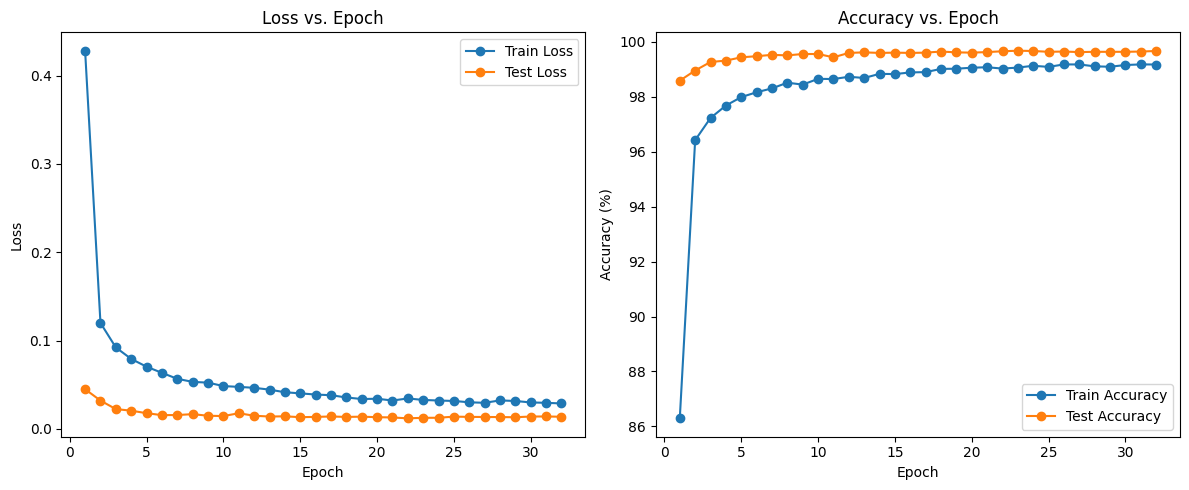

FileNotFoundError: [Errno 2] No such file or directory: 'MNIST_Model'

In [ ]:
import os
import cv2
import sys
import time
import random
import argparse
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from PIL import Image
import matplotlib.pyplot as plt
import shutil
from google.colab import files

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Increased number of filters in convolutional layers
        self.conv1 = nn.Conv2d(1, 64, 3, 1)  # Input channels: 1, Output channels: 64
        self.conv2 = nn.Conv2d(64, 128, 3, 1)  # Output channels: 128
        self.conv3 = nn.Conv2d(128, 256, 3, 1)  # Added a third convolutional layer
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.4)
        self.fc1 = nn.Linear(256 * 5 * 5, 512)  # Adjusted input size for the new conv layer
        self.fc2 = nn.Linear(512, 256)  # Added an additional fully connected layer
        self.fc3 = nn.Linear(256, 10)  # Output layer

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.conv3(x)  # Added the third convolutional layer
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)  # Added the additional fully connected layer
        x = F.relu(x)
        x = self.fc3(x)
        output = F.log_softmax(x, dim=1)
        return output

# Custom transformation to add Gaussian noise
class AddGaussianNoise:
    def __init__(self, mean=0., std=0.1):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)


# Custom transformation
class RandomPixelDrop:
    def __init__(self, max_blobs=3, min_radius=2, max_radius=5, intensity=0.7):
        self.max_blobs = max_blobs         # Maximum number of blobs to create
        self.min_radius = min_radius       # Minimum radius of blobs
        self.max_radius = max_radius       # Maximum radius of blobs
        self.intensity = intensity         # Threshold for blob intensity
        self.background_value = (0 - 0.1307) / 0.3081  # Normalized background value

    def __call__(self, tensor):
        # Create a copy to modify
        modified = tensor.clone()

        # Generate random blobs
        for _ in range(random.randint(1, self.max_blobs)):
            # Create random position within digit bounds
            height, width = tensor.shape[1:]
            cx = random.randint(0, width-1)
            cy = random.randint(0, height-1)

            # Create grid
            x = torch.arange(width, dtype=torch.float32)
            y = torch.arange(height, dtype=torch.float32)
            grid_x, grid_y = torch.meshgrid(x, y, indexing='xy')

            # Generate random radius
            radius = random.randint(self.min_radius, self.max_radius)

            # Create circular mask
            mask = ((grid_x - cx)**2 + (grid_y - cy)**2) < radius**2
            mask = mask.float().unsqueeze(0)

            # Apply random intensity variation
            mask *= random.uniform(0.8, 1.2)

            # Threshold to create binary mask
            blob_mask = (mask > self.intensity).float()

            # Only apply to digit pixels
            digit_area = (modified > -0.5).float()  # Wider threshold for digit region
            combined_mask = (blob_mask * digit_area).bool()

            # Apply to tensor
            modified[combined_mask] = self.background_value

        return modified

    def __repr__(self):
        return (f'{self.__class__.__name__}(max_blobs={self.max_blobs}, '
                f'radius=({self.min_radius}-{self.max_radius}), '
                f'intensity={self.intensity})')

# Training Function
def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = torch.nn.functional.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

        if batch_idx % args.log_interval == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

    train_loss /= len(train_loader)
    accuracy = 100. * correct / len(train_loader.dataset)
    return train_loss, accuracy

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += torch.nn.functional.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)

    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.0f}%)\n')

    return test_loss, accuracy

# Train and Evaluate
def train_and_evaluate(args, model, device, train_loader, test_loader, optimizer, scheduler):
    test_losses = []
    test_accuracies = []
    train_losses = []
    train_accuracies = []

    best_test_loss = float('inf')  # Initialize with a very high value
    best_test_accuracy = float('inf')  # Initialize with a very high value

    patience = 10  # Number of epochs to wait for improvement
    no_improvement_count = 0  # Counter for epochs without improvement

    # Create the "MNIST_Model" directory if it doesn't exist
    model_dir = f"MNIST_Model_seed_{args.seed}"
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    for epoch in range(1, args.epochs + 1):
        train_loss, train_accuracy = train(args, model, device, train_loader, optimizer, epoch)
        test_loss, test_accuracy = test(model, device, test_loader)

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        # Check if the current test loss is the best so far
        if test_loss < best_test_loss or test_accuracy > best_test_accuracy:
            best_test_loss = test_loss
            no_improvement_count = 0  # Reset the counter since we have improvement
            if args.save_model and epoch > 4:
                model_filename = f"mnist_cnn_epoch:{epoch}_test-accuracy:{test_accuracy:.4f}_test-loss:{test_loss:.4f}.pt"
                model_path = os.path.join(model_dir, model_filename)  # Save model in the "MNIST_Model" directory
                try:
                    torch.save(model.state_dict(), model_path)
                    print(f"Model saved with new best test loss: {best_test_loss:.4f} \n")
                except Exception as e:
                    print(f"Error saving model: {e}")
        else:
            no_improvement_count += 1  # Increment the counter since there's no improvement

        # Early stopping check
        if no_improvement_count >= patience:
            print(f"\nEarly stopping triggered after {epoch} epochs. No improvement in test loss for {patience} consecutive epochs.")
            break

        scheduler.step()

    return train_losses, train_accuracies, test_losses, test_accuracies

# Plot graphs
def plot_results(train_losses, train_accuracies, test_losses, test_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Plot Train Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'o-', label='Train Loss')
    plt.plot(epochs, test_losses, 'o-', label='Test Loss')
    plt.title('Loss vs. Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'o-', label='Train Accuracy')
    plt.plot(epochs, test_accuracies, 'o-', label='Test Accuracy')
    plt.title('Accuracy vs. Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Main function
def main():
    # Generate a random seed
    random_seed = random.randint(0, 100000)
    print(f"Using random seed: {random_seed}")

    # Set the seed for reproducibility
    torch.manual_seed(random_seed)
    random.seed(random_seed)

    # Running in a Jupyter notebook
    args = argparse.Namespace(
        batch_size=64,
        test_batch_size=128,
        epochs=500,
        lr=1,
        gamma=0.9, # Factor for adjusting the learning rate in the scheduler, reducing it over time.
        no_cuda=False, # can use the GPU if available
        no_mps=False, #  can use the MPS if available
        dry_run=False, # If True, performs a quick single pass to test the setup.
        seed=random_seed,
        log_interval=10, # Determines how often to log training progress (e.g., every 10 batches).
        save_model=True
    )

    # Device Setup
    use_cuda = not args.no_cuda and torch.cuda.is_available()
    use_mps = not args.no_mps and torch.backends.mps.is_available()

    torch.manual_seed(args.seed)

    if use_cuda:
        device = torch.device("cuda")
    elif use_mps:
        device = torch.device("mps")
    else:
        device = torch.device("cpu")

    # Data Loading
    train_kwargs = {'batch_size': args.batch_size}
    test_kwargs = {'batch_size': args.test_batch_size}

    if use_cuda:
        cuda_kwargs = {'num_workers': 1,
                       'pin_memory': True,
                       'shuffle': True}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)

    # Data Loading with Augmentation for Training
    transform_train = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize((0.1307,), (0.3081,)),
      transforms.RandomAffine(degrees=(-5,5), translate=(0.1, 0.1), scale=(0.6, 1.3), shear=10),
      transforms.RandomApply([AddGaussianNoise(mean=0., std=0.1)], p=0.2),  # Add Gaussian noise
      transforms.RandomApply([RandomPixelDrop(
          max_blobs=2,
          min_radius=1,
          max_radius=2,
          intensity=0.6
      )], p=0.4)
  ])

    # Transform for testing (no augmentation)
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    # Dataset and DataLoader
    dataset1 = datasets.MNIST('../data', train=True, download=True,
                       transform=transform_train)
    dataset2 = datasets.MNIST('../data', train=False,
                       transform=transform_test)

    train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
    test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

    # Model and Optimizer Initialization
    model = Net().to(device)
    optimizer = optim.Adadelta(model.parameters(), lr=args.lr) # optimizer: Adadelta / SGD / Adam
    scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)

    # Train and Evaluate
    train_losses, train_accuracies, test_losses, test_accuracies = train_and_evaluate(args, model, device, train_loader, test_loader, optimizer, scheduler)

    # Plot Results
    plot_results(train_losses, train_accuracies, test_losses, test_accuracies)

    # Compress the folder into a zip file
    shutil.make_archive(model_dir, 'zip', model_dir)  # Use the same folder name

    # Download the zip file in Google Colab
    files.download(f'{model_dir}.zip')  # Download the zip file with the correct name

if __name__ == '__main__':
    main()